## Imports principais

In [28]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import scipy.stats as stats
from sklearn.decomposition import PCA
#import osmnx as ox
#networkx.algorithms.community.community_generators.LFR_benchmark_graph
from networkx.algorithms.community.community_generators import LFR_benchmark_graph
from networkx.algorithms import community
from community import community_louvain
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
from sklearn.metrics import normalized_mutual_info_score as nmi
import igraph
import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

## Definições de funções
### Aqui serão definidas as funções utilizadas no restante do código, facilitando a leitura do código nos enunciados.


In [3]:
def betweenessCentrality(graph):
    x = dict(nx.betweenness_centrality(graph))
    x = pd.Series(x)
    return x

def closenessCentrality(graph):
    x = dict(nx.closeness_centrality(graph))
    x = pd.Series(x)
    return x

def communicabilityCentrality(graph):
    x = pd.DataFrame(nx.communicability_exp(graph))
    x = pd.Series(np.diag(x))
    return x

def degrees(graph):
    x = dict(nx.degree(graph))
    x = pd.Series(x)
    return x

def eigenVectorCentrality(graph,max_iter=100):
    x = dict(nx.eigenvector_centrality(graph, max_iter=max_iter))
    x = pd.Series(x)
    return x

def kCore(graph):
    x = dict(nx.core_number(graph))
    x = pd.Series(x)
    return x

def knnDegree(graph):
    x = dict(nx.average_degree_connectivity(graph))
    degrees = pd.Series(list(x.keys()))
    knn = pd.Series(list(x.values()))
    return degrees, knn

def pageRank(graph, alpha=0.85):
    x = dict(nx.pagerank(graph, alpha=alpha))
    x = pd.Series(x)
    return x

def plotCorr(corr):
    import matplotlib.pyplot as plt
    f = plt.figure(figsize=(10, 10))
    plt.matshow(corr, fignum=f.number)
    plt.xticks(range(corr.shape[0]), corr.columns, fontsize=12, rotation=90)
    plt.yticks(range(corr.shape[1]), corr.columns, fontsize=12)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=12)
    plt.title('Correlation Matrix', fontsize=14,y=1);
    plt.show()

#Fonte: Material de aula
def printInfo(graph):
    N = len(graph)
    M = graph.number_of_edges()
    print('Nós:', N)
    print('Arestas:', M)
    print('Grau Médio:', 2*M/N)

#Similar ao da lista 1, mas saída está em pd.Series    
def random_walk(g, steps=100):
    g_mat = nx.to_numpy_array(g, nodelist=sorted(g.nodes()))    
    path = np.zeros((steps,), dtype=np.int64)
    step = 0
    for i in range(steps-1):
        path[i] = step
        step = np.random.choice(np.arange(g_mat.shape[1])[g_mat[step, :] > 0.0])
    path[i+1] = step
    return pd.Series(path)

#m ==> degree of the moment
def moment(vector, m):
    total = vector.sum()
    probs = vector / total
    moment = np.sum((vector**m)*probs)
    return moment

def shannonEntropy(vector):
    total = vector.sum()
    probs = vector / total
    H = np.sum(np.array([probs[i]*np.log2(probs[i]) if probs[i] != 0 else 0 for i in range(0,len(vector))]))
    H *= -1
    return H
    


## Leitura dos grafos principais (apenas o maior componente conexo é mantido).

In [4]:
# Airport
airport = nx.read_edgelist("datasets/USairport_2010.txt", nodetype=int, data=(('weight',float),))
airport = airport.to_undirected()
airport = max(nx.connected_component_subgraphs(airport), key=len)
airport = nx.convert_node_labels_to_integers(airport, first_label=0)
print("\n\nUSA Airport")
printInfo(airport)

# c-elegans neural
celegans = nx.read_edgelist('datasets/C-elegans-frontal.txt')
celegans = celegans.to_undirected()
celegans = max(nx.connected_component_subgraphs(celegans), key=len)
celegans = nx.convert_node_labels_to_integers(celegans, first_label=0)
print("\n\nC-Elegans")
print("Fonte: https://snap.stanford.edu/data/C-elegans-frontal.html\nA versao em .gml estava dando erro.")
printInfo(celegans)

# c-elegans 2004
celegans2004 = nx.read_edgelist('datasets/C-elegans-2004.txt')
celegans2004 = max(nx.connected_component_subgraphs(celegans2004), key=len)
celegans2004 = celegans2004.to_undirected()
celegans2004 = nx.convert_node_labels_to_integers(celegans2004, first_label=0)
print("\n\nC-Elegans 2004")
printInfo(celegans2004)

# c-elegans 2007
celegans2007 = nx.read_edgelist('datasets/C-elegans-2007.txt')
celegans2007 = celegans2007.to_undirected()
celegans2007 = max(nx.connected_component_subgraphs(celegans2007), key=len)
celegans2007 = nx.convert_node_labels_to_integers(celegans2007, first_label=0)
print("\n\nC-Elegans 2007")
printInfo(celegans2007)

#E-Roads
e_road = nx.read_edgelist('datasets/euroroad', comments='%')
e_road = e_road.to_undirected()
e_road = max(nx.connected_component_subgraphs(e_road), key=len)
e_road = nx.convert_node_labels_to_integers(e_road, first_label=0)
print("E-Roads")
printInfo(e_road)

# Hamsterster Friends
ham = nx.read_edgelist('datasets/hamsterster', comments='%')
ham = max(nx.connected_component_subgraphs(ham), key=len)
ham = ham.to_undirected()
ham = nx.convert_node_labels_to_integers(ham, first_label=0)
print("\n\nHamsterster Friends")
printInfo(ham)

#Human Protein
protein = nx.read_edgelist("datasets/out.maayan-vidal", comments='%')
protein = max(nx.connected_component_subgraphs(protein), key=len)
protein = protein.to_undirected()
protein = nx.convert_node_labels_to_integers(protein, first_label=0)
print("\n\nHuman Protein")
printInfo(protein)

#Karate Club
karate = nx.karate_club_graph()
karate = max(nx.connected_component_subgraphs(karate), key=len)
karate = karate.to_undirected()
karate = nx.convert_node_labels_to_integers(karate, first_label=0)
print("\n\nKarate Club")
printInfo(karate)

#Power Grid
power_grid = nx.read_gml('datasets/power.gml', label=None)
power_grid = max(nx.connected_component_subgraphs(power_grid), key=len)
power_grid = power_grid.to_undirected()
power_grid = nx.convert_node_labels_to_integers(power_grid, first_label=0)
print("\n\nPower Grid")
printInfo(power_grid)

#R Dependencies
r_dependencies = nx.read_edgelist('datasets/Rdependencies.csv', comments='%', delimiter=',',nodetype=str)
r_dependencies = max(nx.connected_component_subgraphs(r_dependencies), key=len)
r_dependencies = r_dependencies.to_undirected()
r_dependencies = nx.convert_node_labels_to_integers(r_dependencies, first_label=0)
print("\n\nR Dependencies")
printInfo(r_dependencies)

#4 Cidades
#Colocar leitura das 4 cidades aqui usando osmnx como plkaceholder
#clovelly = ox.graph_from_place('Clovelly, Devon, South West England, England, EX39 5TQ, United Kingdom', which_result=2)
#walsdorf = ox.graph_from_place('Walsdorf, Landkreis Bamberg, Upper Franconia, Bavaria, 96194, Germany', which_result=1)
#emilion = ox.graph_from_place('Saint-Émilion, Libourne, Gironde, New Aquitaine, Metropolitan France, 33330, France', which_result=1)


#Besalu
with open('datasets/besalu','rb') as gfile:
    besalu = pickle.load(gfile)
besalu = besalu.to_undirected()
besalu = max(nx.connected_component_subgraphs(besalu), key=len)
besalu = nx.convert_node_labels_to_integers(besalu, first_label=0)
print("\n\nBesalu")
printInfo(besalu)


#Clovelly
with open('datasets/clovelly','rb') as gfile:
    clovelly = pickle.load(gfile)
clovelly = clovelly.to_undirected()
clovelly = max(nx.connected_component_subgraphs(clovelly), key=len)
clovelly = nx.convert_node_labels_to_integers(clovelly, first_label=0)
print("\n\nClovelly")
printInfo(clovelly)

#Walsdorf
with open('datasets/walsdorf','rb') as gfile:
    walsdorf = pickle.load(gfile)
walsdorf = walsdorf.to_undirected()
walsdorf = max(nx.connected_component_subgraphs(walsdorf), key=len)
walsdorf = nx.convert_node_labels_to_integers(walsdorf, first_label=0)
print("\n\nWalsdorf")
printInfo(walsdorf)

#Emilion
with open('datasets/emilion','rb') as gfile:
    emilion = pickle.load(gfile)
emilion = emilion.to_undirected()
emilion = max(nx.connected_component_subgraphs(emilion), key=len)
emilion = nx.convert_node_labels_to_integers(emilion, first_label=0)
print("\n\nEmilion")
printInfo(emilion)

allCities = [(besalu,'Besalu'),(clovelly,'clovelly'), (walsdorf,'walsdorf'), (emilion,'emilion')]




USA Airport
Nós: 1572
Arestas: 17214
Grau Médio: 21.900763358778626


C-Elegans
Fonte: https://snap.stanford.edu/data/C-elegans-frontal.html
A versao em .gml estava dando erro.
Nós: 131
Arestas: 687
Grau Médio: 10.488549618320612


C-Elegans 2004
Nós: 1084
Arestas: 1639
Grau Médio: 3.0239852398523985


C-Elegans 2007
Nós: 1108
Arestas: 1554
Grau Médio: 2.8050541516245486
E-Roads
Nós: 1039
Arestas: 1305
Grau Médio: 2.512030798845043


Hamsterster Friends
Nós: 1788
Arestas: 12476
Grau Médio: 13.955257270693512


Human Protein
Nós: 2783
Arestas: 6438
Grau Médio: 4.626661875673733


Karate Club
Nós: 34
Arestas: 78
Grau Médio: 4.588235294117647


Power Grid
Nós: 4941
Arestas: 6594
Grau Médio: 2.66909532483303


R Dependencies
Nós: 2447
Arestas: 5439
Grau Médio: 4.445443400081733


Besalu
Nós: 375
Arestas: 528
Grau Médio: 2.816


Clovelly
Nós: 135
Arestas: 173
Grau Médio: 2.562962962962963


Walsdorf
Nós: 336
Arestas: 429
Grau Médio: 2.5535714285714284


Emilion
Nós: 562
Arestas: 730
Grau 

## Questões
### Questão 1

In [5]:
corr=dict() #maps a graphname to a pandas DataFrame with the correlations
for graph in [e_road, ham, celegans, airport]:
    d = degrees(graph)
    cc = closenessCentrality(graph)
    kc= kCore(graph)
    bc = betweenessCentrality(graph)
    ec = eigenVectorCentrality(graph,1000)
    pr = pageRank(graph)
    rw = random_walk(graph,100)
    com = communicabilityCentrality(graph)
    metrics = [("Betweeness Centrality", bc),("Closeness Centrality",cc),("Communicability Centrality",com),("Degree",d),\
               ("EigenVector Centrality",ec), ('K-Core',kc) ,("Page Rank",pr),('Random Walk', rw)]
    
    #Makes correlation between the metrics and puts it into a DataFrame
    pdCorr = dict()
    for s1 in range(0,len(metrics)):
        pdCorr[metrics[s1][0]] = dict()
        for s2 in range(0,len(metrics)):
            pdCorr[metrics[s1][0]][metrics[s2][0]] = metrics[s1][1].corr(metrics[s2][1])
    #feeding dictionary
    corr[graph] = pd.DataFrame(pdCorr)

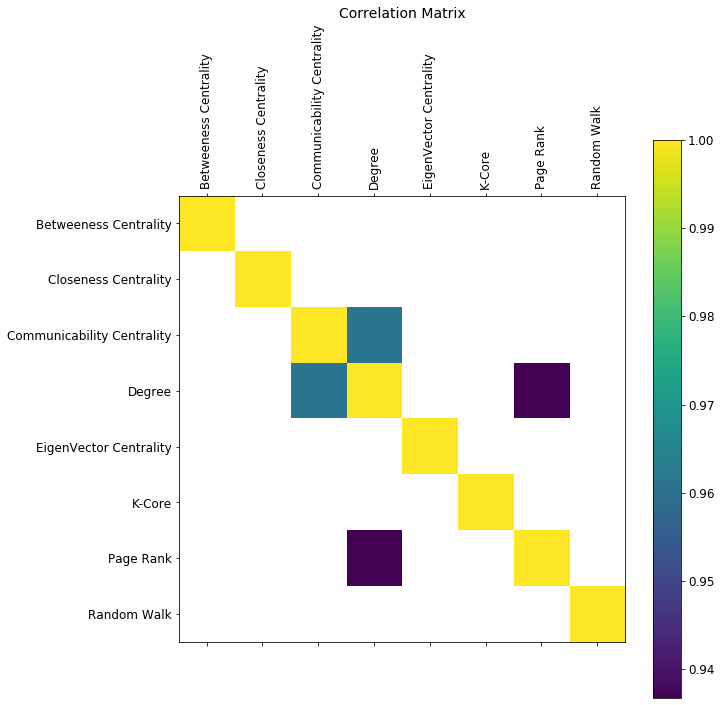

In [6]:
plotCorr(corr[e_road][corr[e_road]>0.9])

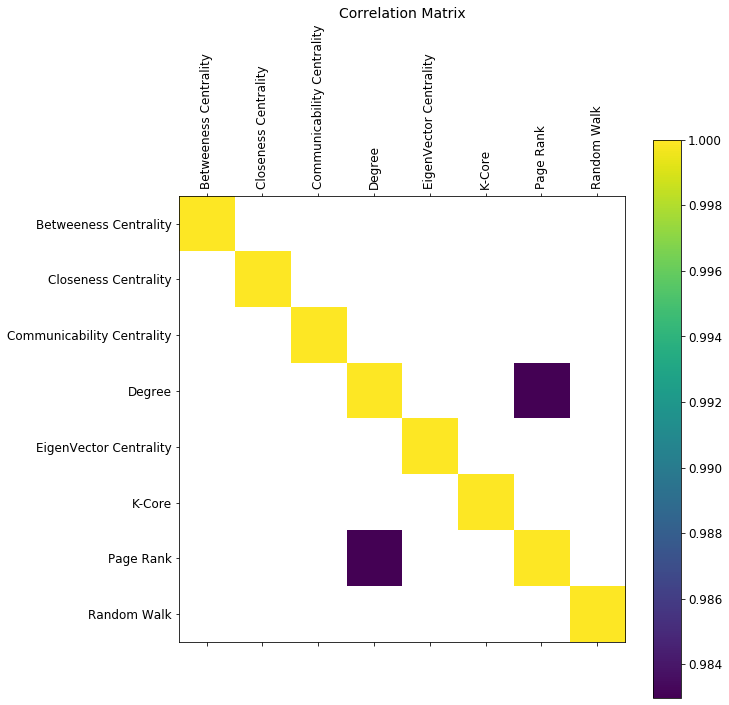

In [7]:
plotCorr(corr[ham][corr[ham]>0.9])

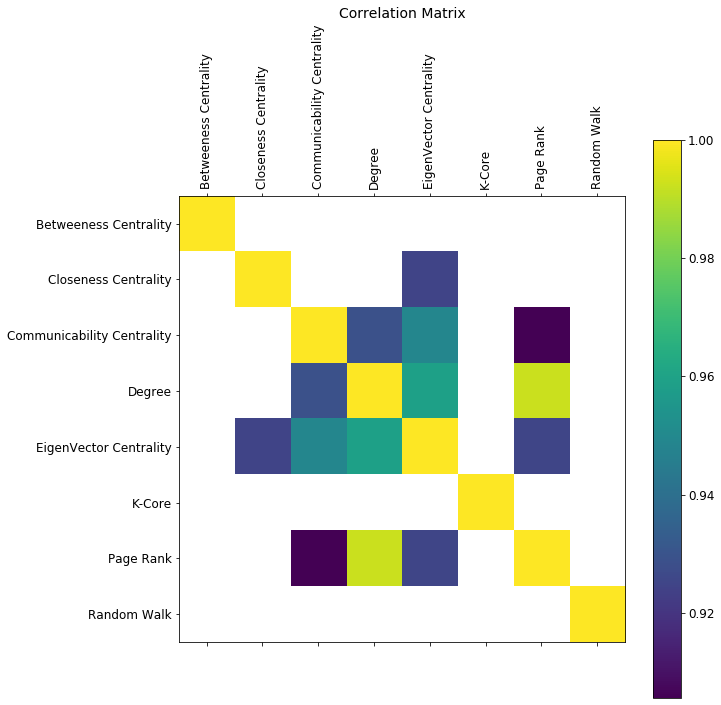

In [8]:
plotCorr(corr[celegans][corr[celegans]>0.9])

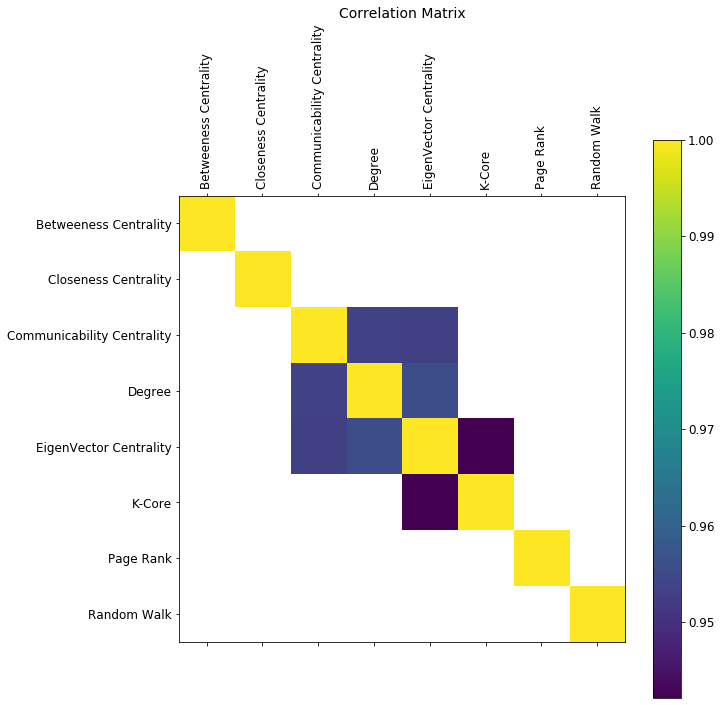

In [9]:
plotCorr(corr[airport][corr[airport]>0.9])

### Questão 2

<Figure size 1800x1800 with 0 Axes>

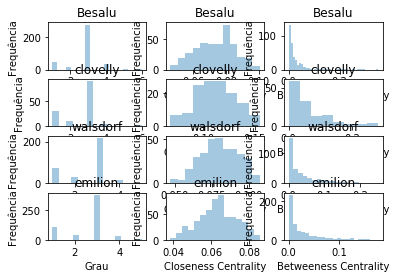

In [10]:
#Ajustar, pois as imagens estão pequenas.
plt.figure(figsize=(25,25));
fig, axis = plt.subplots(4,3)
ng = 0
metric= -1

for g, title in allCities:
    degree = degrees(g)
    closenessC = closenessCentrality(g)
    betweeness = betweenessCentrality(g)
    
    #Plotando
    metric = (metric + 1) % 3
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('Grau')
    axis[ng,metric].set_ylabel('Frequência')
    sns.distplot(degree, hist=True, kde=False, ax=axis[ng,metric]);
    
    metric = (metric + 1) % 3
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('Closeness Centrality')
    axis[ng,metric].set_ylabel('Frequência')
    sns.distplot(closenessC, hist=True, kde=False, ax=axis[ng,metric]);
    
    metric = (metric + 1) % 3
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('Betweeness Centrality')
    axis[ng,metric].set_ylabel('Frequência')
    sns.distplot(betweeness, hist=True, kde=False, ax=axis[ng,metric]);
    ng += 1


Emilion e Walsdorf parecem mais simples de se navegar, uma vez que muitos caminhos passam pelo mesmo lugar (centro provavelmente), Besalu parece ter várias regiões centrais nesse aspecto. Já a usando closeness centrality vemos que Clovelly, Waldorf e Emilion possuem várias regiões que são próximas das outras, i.e. nós com alto cc, indicando que para aqueles que conhecem os menores caminhos da cidade, podem chegar rapidamente aos seus destinos. Besalu parece ser um pouco mais difícil nesse aspecto.

### Questão 3


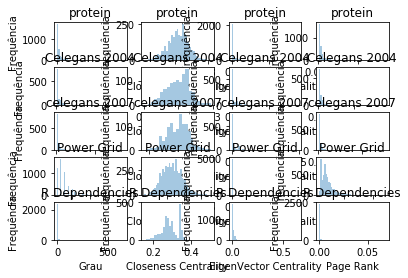

In [11]:
#Ajustar, pois as imagens estão pequenas.
fig, axis = plt.subplots(5,4)
ng = 0
metric= -1

for g, title in [(protein,'protein'), (celegans2004,'Celegans 2004'), (celegans2007,'celegans 2007'),\
                 (power_grid,'Power Grid'), (r_dependencies,'R Dependencies')]:
    
    degree = degrees(g)
    cc = closenessCentrality(g)
    ev = eigenVectorCentrality(g, max_iter = 10000) #1000 estava dando erro em um dos grafos.
    pr = pageRank(g)
    
    #Plotando
    metric = (metric + 1) % 4
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('Grau')
    axis[ng,metric].set_ylabel('Frequência')
    sns.distplot(degree, hist=True, kde=False, ax=axis[ng,metric]);
    
    metric = (metric + 1) % 4
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('Closeness Centrality')
    axis[ng,metric].set_ylabel('Frequência')
    sns.distplot(cc, hist=True, kde=False, ax=axis[ng,metric]);
    
    metric = (metric + 1) % 4
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('EigenVector Centrality')
    axis[ng,metric].set_ylabel('Frequência')
    sns.distplot(ev, hist=True, kde=False, ax=axis[ng,metric]);
    
    metric = (metric + 1) % 4
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('Page Rank')
    axis[ng,metric].set_ylabel('Frequência')
    sns.distplot(pr, hist=True, kde=False, ax=axis[ng,metric]);
    ng += 1

As redes biológicas e geográficas possuem apresentaram poucos hubs fortemente conectados. Já a rede de dependências em R possui muitos hubs conectados a outros hubs, demonstrado pela distribuiçãso do Page Rank.

### Questão 4

In [12]:
graphData = []
graph_names = ['protein','Celegans 2004','celegans 2007','Power Grid','R Dependencies']

for g in [protein,celegans2004,celegans2007,power_grid,r_dependencies]:

    description = []
    d = degrees(g)
    cc = closenessCentrality(graph)
    kc= kCore(graph)
    bc = betweenessCentrality(graph)
    ec = eigenVectorCentrality(graph,1000)
    pr = pageRank(graph)
    rw = random_walk(graph,100)
    com = communicabilityCentrality(graph)

    for x in [d,kc,cc,bc,ec,pr,rw,com]:
        description.append(np.average(x))
        description.append(np.std(x))
        description.append(moment(x,2))
        description.append(shannonEntropy(x))

    graphData.append(description)

print(graphData)

[[4.626661875673733, 7.230040280728264, 737.2749301025165, 10.599521187697299, 12.505725190839694, 18.093638059123293, 2053.5045017549214, 9.518165280002558, 0.3291550995709239, 0.05137671166043366, 0.11637740523360385, 10.600823145506633, 0.0013472381143324291, 0.0078117451663056794, 0.005970086678596225, 6.806119980388889, 0.010728878178602809, 0.022825938941264362, 0.0047676990389196984, 8.69430305040868, 0.0006361323155216287, 0.002434727269825649, 0.000204407882704187, 8.179241130538156, 329.36, 218.02130721560218, 247298.80513723588, 6.220724890147451, 3.9512262022136676e+45, 1.2655931978240108e+46, 2.516574645072806e+93, 7.5290084730765], [3.0239852398523985, 5.591191047370515, 538.6095179987798, 9.14661664830076, 12.505725190839694, 18.093638059123293, 2053.5045017549214, 9.518165280002558, 0.3291550995709239, 0.05137671166043366, 0.11637740523360385, 10.600823145506633, 0.0013472381143324291, 0.0078117451663056794, 0.005970086678596225, 6.806119980388889, 0.010728878178602809,

Text(0, 0.5, 'PC2')

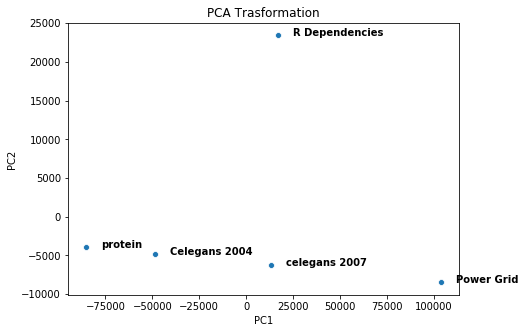

In [13]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(graphData)
transformed = pd.DataFrame(data = principalComponents, columns = ['PC 1', 'PC 2'])

plt.figure(figsize=(7,5));
p1 = sns.scatterplot(x='PC 1',y='PC 2', data=transformed, legend=False);

for line in range(0,len(graphData)):
     p1.text(transformed['PC 1'][line]+8000, transformed['PC 2'][line]-100, graph_names[line],
     horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.title('PCA Trasformation')
plt.xlabel('PC1')
plt.ylabel('PC2')


Podemos ver que todas as redes possuem uma tendência entre os componentes 1 e 2, mas a rede R dependencies possui uma relação diferente.

Como vimos no exercício anterior, a rede R Dependencies apresenta uma distribuição de Page Rank bem diferente das outras, nas 3 outras redes poucos nós dominam o Page Rank, enquanto que na rede de dependências vários nós são "bem relacionados", provavelmente associado a grande quantidade de bibliotecas grandes e co-dependentes. A tendência nos componentes da PCA deve estar capturando essa característica.

### Questão 5



E-Road: -0.0577
Celegans Neural: 0.224
USA Airport: -0.3611
Human Protein: -0.7199


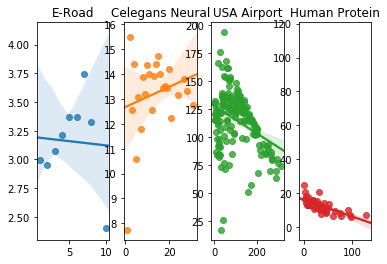

In [14]:
fig, axis = plt.subplots(1,4)
ng = -1
correlations = ""
for g, title in [(e_road,"E-Road"), (celegans,"Celegans Neural"), (airport,"USA Airport"),(protein,'Human Protein')]:
    x, y = knnDegree(g)
    corr = x.corr(y)
    correlations = correlations + "\n"+ title + ": " + str(round(corr,4))
    ng = (ng + 1)
    axis[ng].set_title(title)
    axis[ng].set_xlabel('Grau')
    axis[ng].set_ylabel('Vizinhos Médios Por Grau')
    sns.regplot(x,y, ax=axis[ng]);
    
print(correlations)

Nas redes Airport e Human Protein, conforme o grau aumenta, a quantidade média de vizinhos diminui, indicando que hubs estão conectados a nós pouco conectados, associado a redes dissortativas. Já na Celegans ocorre o inverso. Por fim, na rede E-Roads, apresenta uma rede sem tendência, pois a quantidade de vizinhos de um nó não prevê o grau da vizinhança.

Usando correlação de Pearson podemos ver o quanto o grau de um nó prevê o grau médio de seus vizinhos, além de ser uma medida limitada (-1 a 1), portanto é uma ótima maneira de medir quantitativamente a assortatividade de uma rede.
As redes de Airport e Human Protein, possuem correlação negativa e longe de 0 indicando redes dissortativas, no entanto para a rede de proteínas a relação de que Hubs conectados a nós pouco conectados é mais frequente que na Airport, trazendo um valor absoluto de correlação maior. A rede Celegans possui certa assortatividade mas se aproxima de uma rede sem tendência e a rede E-Roads possui uma correlação muito próxim,a de 0 indicando uma rede sem tendência.

É vválido notar que a correlação de Pearson captura apenas relações lineares entre os atributos, mas uma observação rápida nos gráficos já indica a ausência de outras relações (e.g. de potência).

### Questão 6

/home/gui/.local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


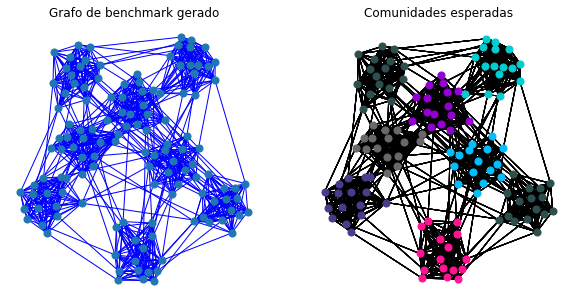

In [15]:
fig, axis = plt.subplots(1,2, figsize=(10,5))
N = 128
tau1 = 3
tau2 = 1.5
mu = 0.04
k =16
minc = 16
maxc = 16
G = LFR_benchmark_graph(n = N, tau1 = tau1, tau2 = tau2, mu = mu, min_degree = k, 
                        max_degree = k, min_community=minc, max_community = maxc, seed = 10)
pos=nx.spring_layout(G)
nx.draw(G, with_labels = False, nodecolor='r', edge_color='b', 
        node_size=50, font_size=16,  width=1,pos = pos, ax=axis[0]);


def plot_expected_comms_benchmark(G, ax=-1):
    communities = {frozenset(G.nodes[v]['community']) for v in G}
    colors = list(matplotlib.colors.cnames.values())
    aux = 35

    for c in communities:
        nx.draw(G.subgraph(c), pos=pos, node_color = colors[aux], with_labels = False, 
            node_size=50, ax=ax)
        aux = aux+1
        nx.draw_networkx_edges(G, pos, ax=ax)

    return communities
true_comms = plot_expected_comms_benchmark(G, axis[1])

axis[0].set_title('Grafo de benchmark gerado');
axis[1].set_title('Comunidades esperadas');

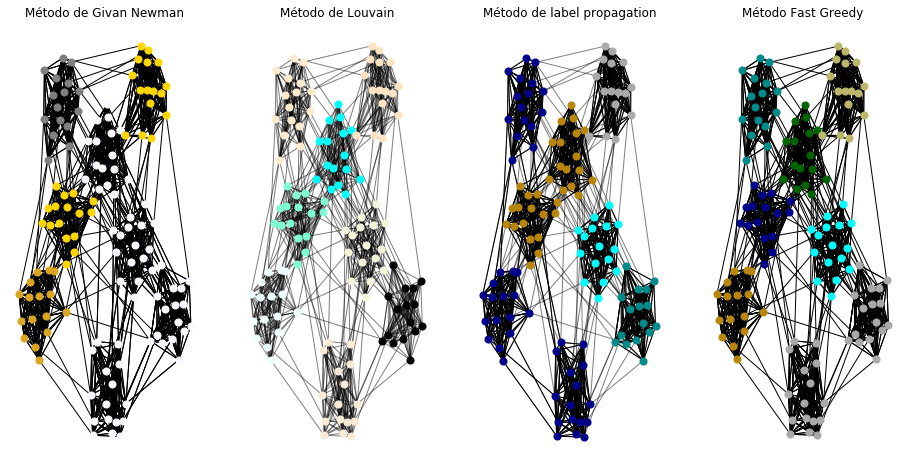

In [72]:
def select_givan_newman_comms(gn_comm, k=3):
    for i in range(k):
        comm = next(gn_comm)
    sorted_comms = sorted(map(sorted, comm))
    return sorted_comms
    
def plot_givan_newman(G, pos, k=3, ax=-1):
    #pos=nx.spring_layout(G)
    gn_comm = community.girvan_newman(G)
    
    sorted_comms = select_givan_newman_comms(gn_comm, k)
    
    colors = list(matplotlib.colors.cnames.values())
    aux = 50
    for comm in sorted_comms:
        nx.draw(G.subgraph(comm), pos=pos, node_color = colors[aux], with_labels = False, 
                node_size=50, ax=ax)
        aux = aux + 1
    nx.draw_networkx_edges(G, pos, ax=ax)
    ax.set_title('Método de Givan Newman')
    return sorted_comms

#Louvain
def plot_louvain(G, pos, ax=-1):
    louvain_comm = community_louvain.best_partition(G)
    
    #pos=nx.spring_layout(G)

    colors = list(matplotlib.colors.cnames.values())

    size = float(len(set(louvain_comm.values())))
    count = 0.
    for com in set(louvain_comm.values()) :
        count = count + 1.
        list_nodes = [nodes for nodes in louvain_comm.keys() if louvain_comm[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 50, 
                               node_color = colors[int(count)], ax=ax)
    nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)
    ax.set_title('Método de Louvain')
    ax.axis('off')
    return louvain_comm

def plot_label_prop(G, pos, ax=-1):
    #pos = nx.spring_layout(G)
    lp_comm = community.label_propagation_communities(G)
    lp_comm = list(lp_comm)

    colors = list(matplotlib.colors.cnames.values())
    aux = 20
    for comm in lp_comm:
        nx.draw(G.subgraph(comm), pos=pos, node_size = 50, node_color = colors[aux], ax=ax)
        aux = aux+1
        
    nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)
    ax.set_title('Método de label propagation')
    return lp_comm

def plot_fast_greedy(G, pos, ax=-1):
    #pos = nx.spring_layout(G)
    comms = greedy_modularity_communities(G)

    colors = list(matplotlib.colors.cnames.values())
    aux = 20
    
    for c in comms:
        nx.draw(G.subgraph(c), pos=pos, node_color = colors[aux], with_labels = False, 
        node_size=50, ax=ax)
        aux = aux+1
        
    nx.draw_networkx_edges(G, pos, ax=ax)    
    ax.set_title('Método Fast Greedy')
    return comms
        

fig, axis = plt.subplots(1,4, figsize=(16,8))

gn_comms = plot_givan_newman(G, pos, k=3, ax=axis[0])
lv_comms = plot_louvain(G, pos, ax=axis[1])
lp_comms = plot_label_prop(G, pos, ax=axis[2])
fg_comms = plot_fast_greedy(G, pos, ax=axis[3])

In [51]:
df = pd.DataFrame(columns=['Target','Givan-Newmann','Louvain','Label Propagation', 'Fast Greedy'])
for node in G.nodes():
    df = df.append(pd.Series(name=node));

for index, comm in enumerate(true_comms):
    for node in comm:
        df['Target'].iloc[node] = index;

for index, comm in enumerate(gn_comms):
    for node in comm:
        df['Givan-Newmann'].iloc[node] = index;

for node, comm in lv_comms.items():
    df['Louvain'].iloc[node] = comm;

for index, comm in enumerate(lp_comms):
    for node in comm:
        df['Label Propagation'].iloc[node] = index;

for index, comm in enumerate(fg_comms):
    for node in comm:
        df['Fast Greedy'].iloc[node] = index;

print(df)

     Target  Givan-Newmann  Louvain  Label Propagation  Fast Greedy
0         5              0        0                  1            6
1         4              0        1                  3            5
2         7              1        2                  3            1
3         0              2        3                  1            3
4         5              0        0                  1            6
..      ...            ...      ...                ...          ...
123       3              1        5                  4            7
124       4              0        1                  3            5
125       5              0        0                  1            6
126       5              0        0                  1            6
127       3              1        5                  4            7

[128 rows x 5 columns]


In [52]:
#comms_df = df.copy()
#print(comms_df[comms_df['Givan-Newmann'] == 0][['Target','Givan-Newmann']])
print('Givan-Newmann: ', nmi(df['Target'], df['Givan-Newmann']));
print('Louvain', nmi(df['Target'], df['Louvain']));
print('Label Propagation', nmi(df['Target'], df['Label Propagation']));
print('Fast Greedy', nmi(df['Target'], df['Fast Greedy']));

Givan-Newmann:  0.7637626158259732
Louvain 1.0
Label Propagation 0.8476711355688137
Fast Greedy 1.0


## Questão 7

### Método de Girvan-Newmann

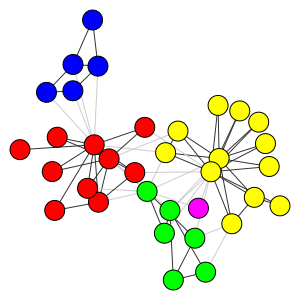

In [93]:
nx.write_edgelist(karate, 'ex7', data=False)
ig_karate = igraph.Graph.Read_Edgelist('ex7', directed=False)
ig_layout = ig_karate.layout('fr')

igraph.plot(ig_karate.community_edge_betweenness().as_clustering(), layout=ig_layout, bbox=[0,0,300,300])

### Método de Louvain

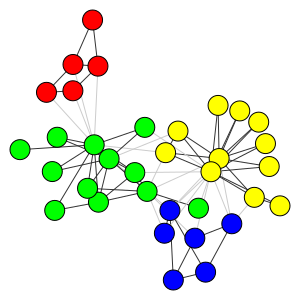

In [99]:
igraph.plot(ig_karate.community_multilevel(), layout=ig_layout, bbox=[0,0,300,300])

### Método de label propagation

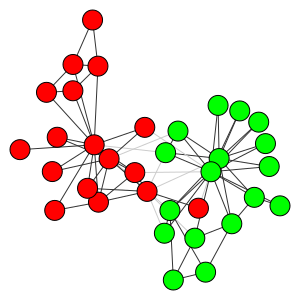

In [94]:
igraph.plot(ig_karate.community_label_propagation(), layout=ig_layout, bbox=[0,0,300,300])

### Método Fast Greedy

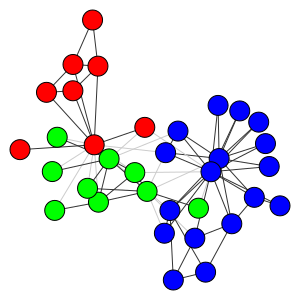

In [95]:
igraph.plot(ig_karate.community_fastgreedy().as_clustering(), layout=ig_layout, bbox=[0,0,300,300])

### Método Netcarto (Simulated Annealing)

Método de Simulated Annealing (Netcarto)


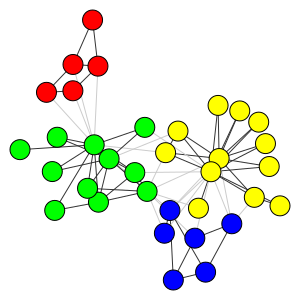

In [97]:
igraph.plot(ig_karate.community_spinglass(), layout=ig_layout, bbox=[0,0,300,300])

### Método Infomap

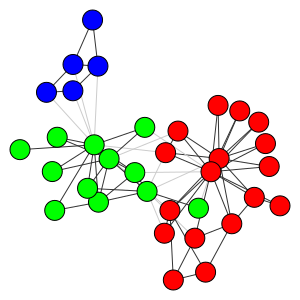

In [100]:
igraph.plot(ig_karate.community_infomap(), layout=ig_layout, bbox=[0,0,300,300])

## Exercício 8